# makemore: part 3

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [34]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [35]:
len(words)

32033

In [36]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [37]:
# build the dataset
# creating test, dev, train files
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [38]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


<h3> Loss Expectation</h3> <h4> Scrutinize the initialization</h4>

In [39]:
#4-dimensional example and issue

# based on this we perform our observation because the probability of next element occuring is same for all

logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [40]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix  = torch.randint(0, Xtr.shape[0],(batch_size,), generator = g) #Note 1
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y (inputs)
    
    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer pre activation, b1 will be set to comment later
    h = torch.tanh(hpreact)
    logits = h@W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
     # update
    lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad
        
    #track status
    
    if i% 10000 ==0: # to print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') 
    lossi.append(loss.log10().item())
    #see how the initial loss is at 27... which is a  bug
    break
    

      0/ 200000: 27.8817


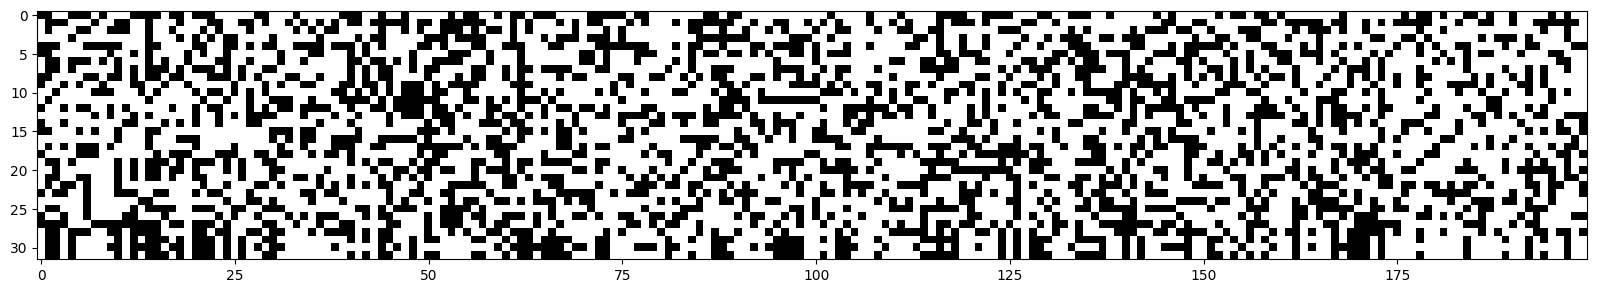

In [41]:
plt.figure(figsize =(20,10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = 'nearest')

(array([2460.,  199.,  126.,  114.,  113.,   97.,  119.,  131.,  185.,
        2856.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

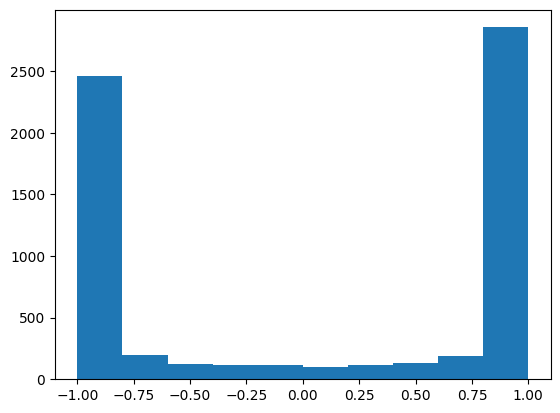

In [42]:
plt.hist(h.view(-1).tolist())

In [43]:
logits[0]
# we need below logits to be closer to 0 but as we can see that is not the case
# to correct initial loss 27 we see what has impact on logits = h@W2 +b2
#since we want the logits to be closer to 0 we dont wanna be adding or subtracting
#instead we multiply by 0, so that b2 is 0 at initialization
#we also want W2(weight assigned to be smaller) bcoz we need logits to be closer to 0






tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [44]:
#rectifying the bug
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.1
b1 = torch.randn(n_hidden,                        generator=g) *0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0.01
b2 = torch.randn(vocab_size,                      generator=g) *0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
  

      0/ 200000: 3.3147


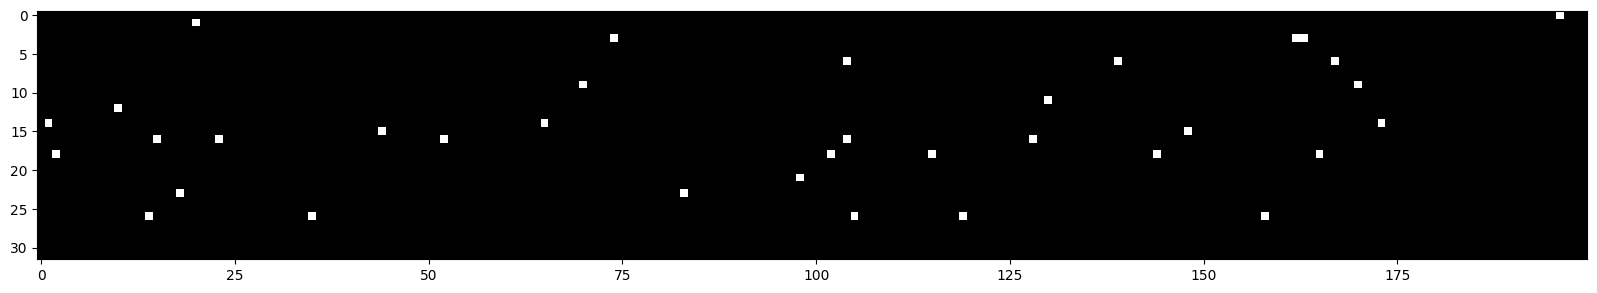

In [46]:
plt.figure(figsize =(20,10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = 'nearest')

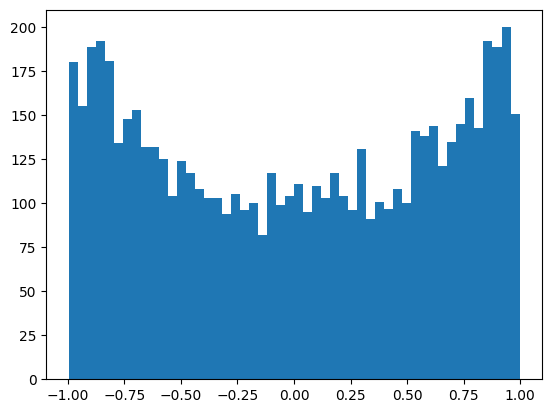

In [47]:
plt.hist(h.view(-1).tolist(),50);

In [48]:
#Note -1
#what is ix?
# => Input (converted into tensors) taken in batches
for i in range(max_steps):
    #minibatch construct
    ix  = torch.randint(0, Xtr.shape[0],(batch_size,), generator = g)
ix

tensor([144005,  14777, 149250,  56102, 145638,  29638,  82934,  17049, 100123,
          2588, 130968, 146193, 137064, 175849,  68431,  48332,  56503, 100022,
        142361,  93458, 150495,  44491, 136406, 133589, 137644,  38767,   1960,
        141852,  33580,  94341, 132212, 116991])

In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.2995
  10000/ 200000: 2.0078
  20000/ 200000: 2.3611
  30000/ 200000: 2.2434
  40000/ 200000: 2.4078
  50000/ 200000: 2.3356
  60000/ 200000: 2.3912
  70000/ 200000: 2.0260
  80000/ 200000: 2.0898
  90000/ 200000: 1.8740
 100000/ 200000: 2.1489
 110000/ 200000: 1.8778
 120000/ 200000: 2.0097
 130000/ 200000: 1.9785
 140000/ 200000: 2.5252
 150000/ 200000: 2.3878
 160000/ 200000: 1.8295
 170000/ 200000: 1.9995
 180000/ 200000: 1.7748
 190000/ 200000: 2.1045


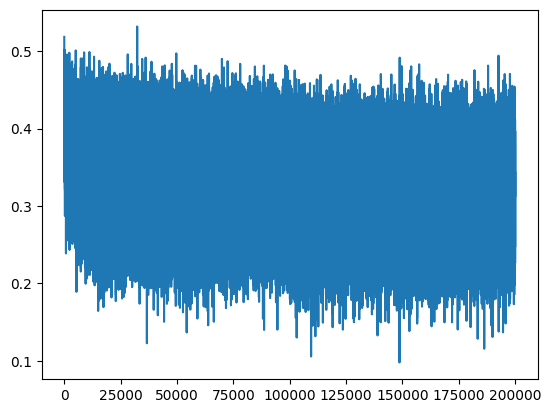

In [50]:
plt.plot(lossi)

tensor(0.0082) tensor(0.9969)
tensor(0.0045) tensor(3.0970)


(array([7.06087250e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.82434900e-05, 1.41217450e-05, 2.82434900e-05, 3.53043625e-05,
        1.20034832e-04, 1.76521812e-04, 3.67165370e-04, 5.29565437e-04,
        1.05207000e-03, 1.77227900e-03, 2.85259249e-03, 4.58956712e-03,
        7.18796820e-03, 1.14951004e-02, 1.74474159e-02, 2.51296452e-02,
        3.63917369e-02, 5.23069435e-02, 6.81444805e-02, 9.02238288e-02,
        1.09591802e-01, 1.25860052e-01, 1.36945622e-01, 1.37694075e-01,
        1.28846801e-01, 1.14124882e-01, 9.40931869e-02, 7.27128650e-02,
        5.39803702e-02, 3.87783118e-02, 2.71349330e-02, 1.89584427e-02,
        1.23353443e-02, 7.98584679e-03, 5.28859350e-03, 3.21269699e-03,
        2.09707913e-03, 1.16504396e-03, 6.28417652e-04, 3.88347987e-04,
        2.18887047e-04, 9.17913425e-05, 6.35478525e-05, 4.94261075e-05,
        0.00000000e+00, 2.82434900e-05]),
 array([-19.18501854, -18.47689075, -17.76876297, -17.06063519,
        -16.3525074 , -15.6443

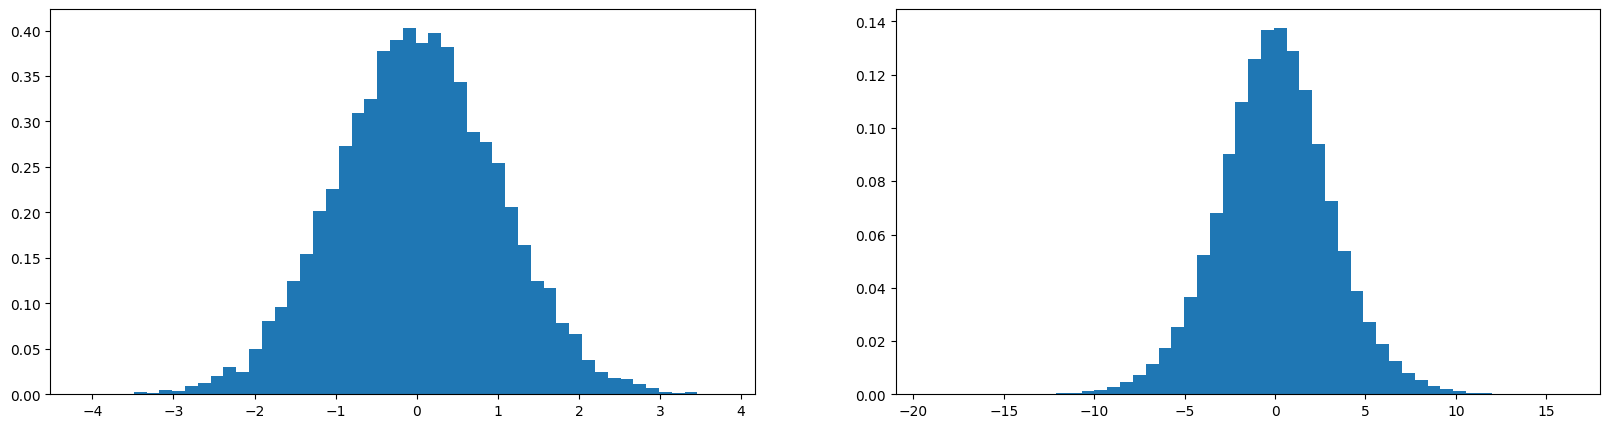

In [51]:
# Kaiming init
x = torch.randn(1000,10) 
w = torch.randn(10,200)#"fan in" is basically the number of input here, i.e. 10
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)

plt.hist(x.view(-1).tolist(),50, density= True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density= True)

#In the above expression, the weight w is directly impacting the . 
#So when the weight is adjusted through backward propagation, our output also increases or decreases
#depending upon the amount of weight adjusted

# So Kaiming init states that there is a proper way to adjust the change in weight to the output

# focusing on  how do we initialize the weight so that the neural activation stay at reasonable value

#and the answer is divide the weight by square root of fan in

# now the output y will have exactly the standard deviation of 1 . 

#how do we initialize the weight so that the neural activation stay at reasonable value

#Convolutional neural network


In [18]:
""" In Kaiming init they used ReLU as a squashing function
- since they use squashing function all the negative numbers are 
clamed to zero  so that only positive numbers are passed through
so half of the distribution are thrown away ignoring negative fucntions

# So in Kaiming init they try to compensate it by a gain..

###VERY VERY IMPORTANT
-find a way to include negative function also
-because there still exists correlation in between those negative numbers and
the whole network

even if we use the positive number after whole squashing , the relationn in the neural 
network to some extent are ignored

 
use  
 
 
 
	"""

' In Kaiming init they used ReLU as a squashing function\n- since they use squashing function all the negative numbers are \nclamed to zero  so that only positive numbers are passed through\nso half of the distribution are thrown away ignoring negative fucntions\n\n# So in Kaiming init they try to compensate it by a gain..\n\n###VERY VERY IMPORTANT\n-find a way to include negative function also\n-because there still exists correlation in between those negative numbers and\nthe whole network\n\neven if we use the positive number after whole squashing , the relationn in the neural \nnetwork to some extent are ignored\n\n \nuse  \n \n \n \n\t'

tensor(-0.0189) tensor(1.0014)
tensor(0.0037) tensor(1.0072)


(array([2.03990731e-05, 0.00000000e+00, 6.11972192e-05, 1.22394438e-04,
        1.42793511e-04, 3.46784242e-04, 4.07981461e-04, 6.11972192e-04,
        9.99554580e-04, 1.93791194e-03, 3.24345262e-03, 5.20176363e-03,
        8.95519307e-03, 1.61152677e-02, 2.50704608e-02, 3.95334036e-02,
        6.10952238e-02, 9.43865110e-02, 1.36000620e-01, 1.89772577e-01,
        2.58966232e-01, 3.26262774e-01, 3.77648039e-01, 4.22627995e-01,
        4.23035977e-01, 3.96557980e-01, 3.46784242e-01, 2.75999458e-01,
        2.11456791e-01, 1.51993493e-01, 1.07033936e-01, 7.35794565e-02,
        4.74686430e-02, 3.05170133e-02, 1.80327806e-02, 1.09543022e-02,
        6.97648298e-03, 3.83502573e-03, 2.08070545e-03, 1.46873326e-03,
        1.06075180e-03, 5.50774972e-04, 2.44788877e-04, 2.44788877e-04,
        1.63192584e-04, 8.15962922e-05, 1.22394438e-04, 2.03990731e-05,
        0.00000000e+00, 2.03990731e-05]),
 array([-5.92175007, -5.67664089, -5.43153172, -5.18642254, -4.94131336,
        -4.69620419, 

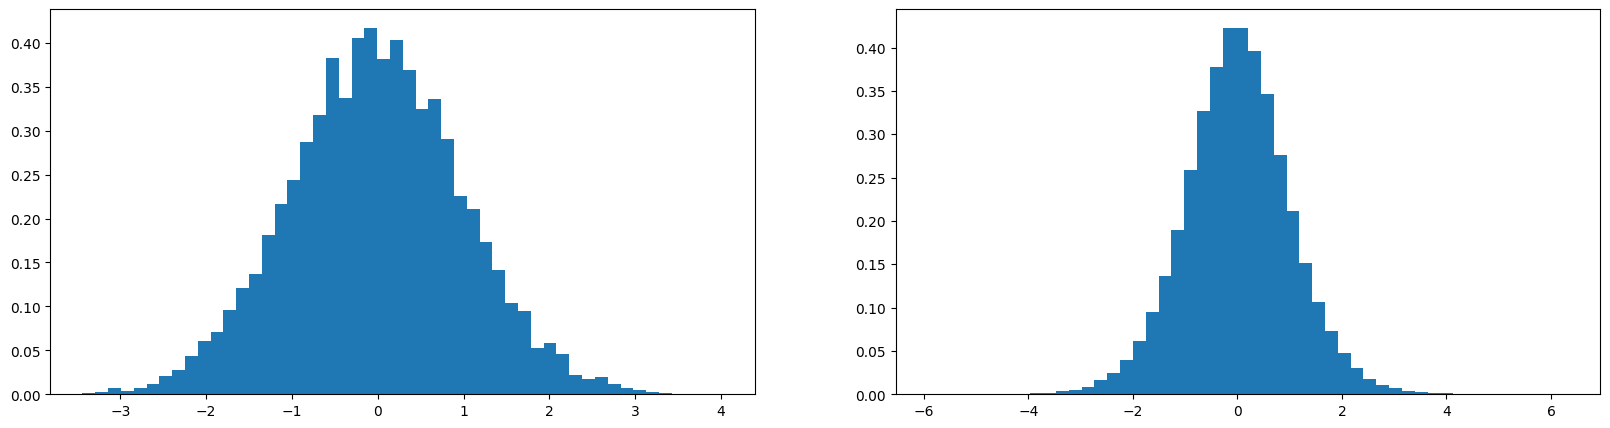

In [52]:
# Kaiming init
x = torch.randn(1000,10) 
w = torch.randn(10,200)/ 10**0.5
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)

plt.hist(x.view(-1).tolist(),50, density= True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density= True)


In [ ]:
"""
 Instead of dividing the weight  by 10**0.5
 Kaiming init suggests that the adjustment = gain/squareroot of fanin
 gain for tanh = 5/3
 fan in = n_embd* block_size =10*3 =30 (10 dimension , 3 characters)
 so the weight is to be adujsted by (5/3)/10**0.5
	"""

 for x tensor(-0.0056) tensor(1.0104)
for y tensor(-0.0006) tensor(0.9943)


(array([2.06495823e-05, 0.00000000e+00, 4.12991645e-05, 0.00000000e+00,
        2.06495823e-05, 1.03247911e-04, 6.19487468e-05, 2.47794987e-04,
        4.95589975e-04, 7.22735380e-04, 1.59001784e-03, 2.16820614e-03,
        3.65497606e-03, 5.67863513e-03, 9.60205576e-03, 1.55491355e-02,
        2.50685929e-02, 3.83875734e-02, 6.33322688e-02, 9.13950511e-02,
        1.31290044e-01, 1.87642754e-01, 2.50747878e-01, 3.22938817e-01,
        3.84660419e-01, 4.30998081e-01, 4.34921502e-01, 4.06858720e-01,
        3.54119686e-01, 2.89796238e-01, 2.15147998e-01, 1.53612243e-01,
        1.07191982e-01, 7.44830433e-02, 4.69365005e-02, 2.90539623e-02,
        2.02985394e-02, 1.25342964e-02, 7.82619168e-03, 4.64615601e-03,
        2.68444570e-03, 1.87911199e-03, 7.84684126e-04, 3.71692481e-04,
        1.44547076e-04, 1.03247911e-04, 4.12991645e-05, 4.12991645e-05,
        0.00000000e+00, 2.06495823e-05]),
 array([-6.35032511, -6.10818946, -5.86605381, -5.62391816, -5.38178251,
        -5.13964686, 

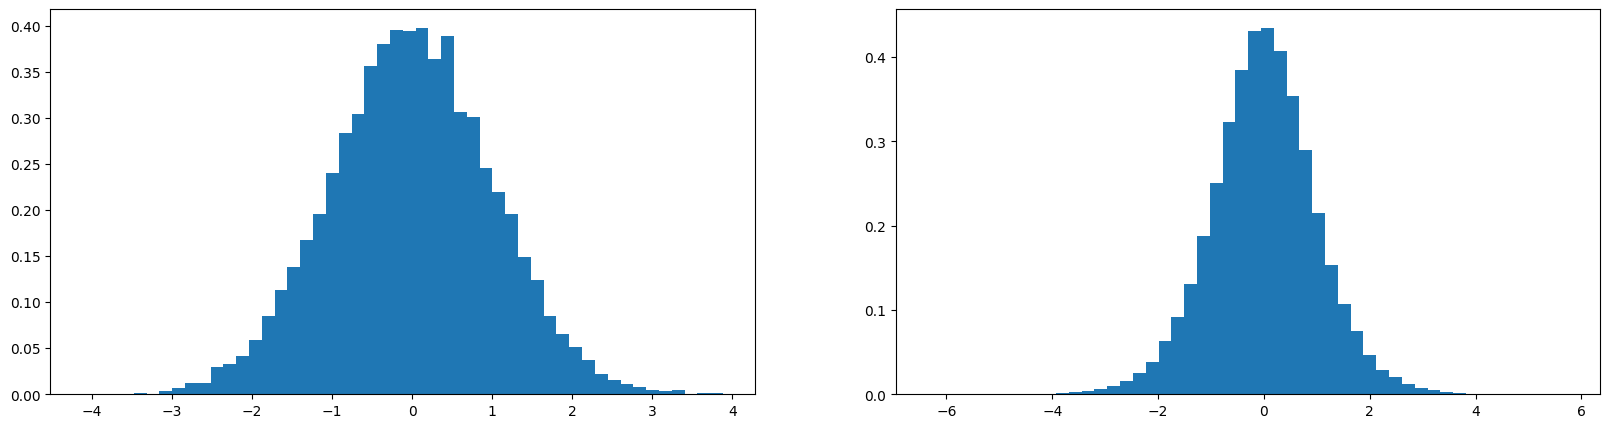

In [53]:
# Kaiming init
x = torch.randn(1000,10) 
w = torch.randn(10,200)* (5/3)/((n_embd* block_size)**0.5)
y = x@w
print(' for x', x.mean(),x.std())
print('for y',y.mean(),y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)

plt.hist(x.view(-1).tolist(),50, density= True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density= True)

In [54]:
#Batch normalization concept
"""
 -We have hidden states (i.e. tanh)
 but we dont want these preactivation state to be too small
 We dont want it to be too large (tanh will be too saturated)
 and we dont want it to be too small (tanh not doing anything)
 
 We want them to be roughly gaussian
 then why not take the hidden state and normalize them to be normal (simple concept better result)
 
"""


hpreact.shape #(32*100)




torch.Size([32, 200])

In [55]:
hpreact.mean(0, keepdim = True).shape #(1*200)

torch.Size([1, 200])

In [56]:
hpreact.std(0,keepdim = True).shape #(1*200)

torch.Size([1, 200])

In [57]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.1
b1 = torch.randn(n_hidden,                        generator=g) *0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0.01
b2 = torch.randn(vocab_size,                      generator=g) *0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True# MLP revisited


12097


In [58]:
n_hidden

200

In [59]:
torch.ones((1, n_hidden)) 

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])

In [60]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  hpreact = (hpreact -hpreact.mean(0,keepdim = True))*bngain/ hpreact.std(0, keepdim = True) +bnbias
  #standardizing = (X- X̅)/σ =>  ((X- X̅)*bnbias/σ ) + bnbias
  #now the output of the hidden layer will be unit gaussian for each neuron, which is very good
  # BatchNorm layer
 
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3147
  10000/ 200000: 2.0957
  20000/ 200000: 2.3464
  30000/ 200000: 2.4123
  40000/ 200000: 2.0225
  50000/ 200000: 2.2993
  60000/ 200000: 2.3973
  70000/ 200000: 2.0961
  80000/ 200000: 2.4386
  90000/ 200000: 2.0998
 100000/ 200000: 1.7981
 110000/ 200000: 2.3842
 120000/ 200000: 1.9283
 130000/ 200000: 2.4509
 140000/ 200000: 2.3811
 150000/ 200000: 2.2322
 160000/ 200000: 1.9277
 170000/ 200000: 1.9031
 180000/ 200000: 2.0793
 190000/ 200000: 1.8532


In [91]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd* block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) *0.01 
#commented becoz batch normalization has its own bias(bnbias) and there is no need to have bias before the batch
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0.01
b2 = torch.randn(vocab_size,                      generator=g) *0


#scale and shift concept
"""we are taking normalized inputs 
then we are scaling some gains 
then we offsetting by bias
"""
# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) #n_hidden =200 (to  multiply later with hidden layer tanh as per papaer suggestion)
bnbias = torch.zeros((1, n_hidden)) #OFFSET with bnbias in tanh later
#bngain, bnbias could be trained using backward propagation so make sure to include in to parameter for backward passing
# BatchNorm buffers
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [61]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 2.2962
  10000/ 200000: 1.7885
  20000/ 200000: 2.4933
  30000/ 200000: 2.5940
  40000/ 200000: 2.2284
  50000/ 200000: 2.3676
  60000/ 200000: 2.3842
  70000/ 200000: 1.8126
  80000/ 200000: 2.2996
  90000/ 200000: 2.1779
 100000/ 200000: 1.7563
 110000/ 200000: 2.1191
 120000/ 200000: 2.0207
 130000/ 200000: 2.3224
 140000/ 200000: 2.0509
 150000/ 200000: 2.4050
 160000/ 200000: 2.1691
 170000/ 200000: 2.0686
 180000/ 200000: 1.9537
 190000/ 200000: 2.1956


In [63]:

# calibrate the batch norm at the end of training
#This step could be avoided..
#caluculate bnmean and bnmean_running, check if they are similar, and if they are similar we can replace 
#the bnmean in hidden layer(tanh) with bnmean_running in split_loss(split)method's hpreact

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  hpreact = (hpreact -hpreact.mean(0,keepdim = True))*bngain/ hpreact.std(0, keepdim = True) +bnbias
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [64]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0462164878845215
val 2.1007111072540283


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [65]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

layer 2 (      Tanh): mean -0.00, std 0.66, saturated: 2.00%
layer 5 (      Tanh): mean +0.01, std 0.51, saturated: 0.00%
layer 8 (      Tanh): mean -0.02, std 0.42, saturated: 0.00%
layer 11 (      Tanh): mean +0.03, std 0.37, saturated: 0.00%
layer 14 (      Tanh): mean -0.02, std 0.35, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

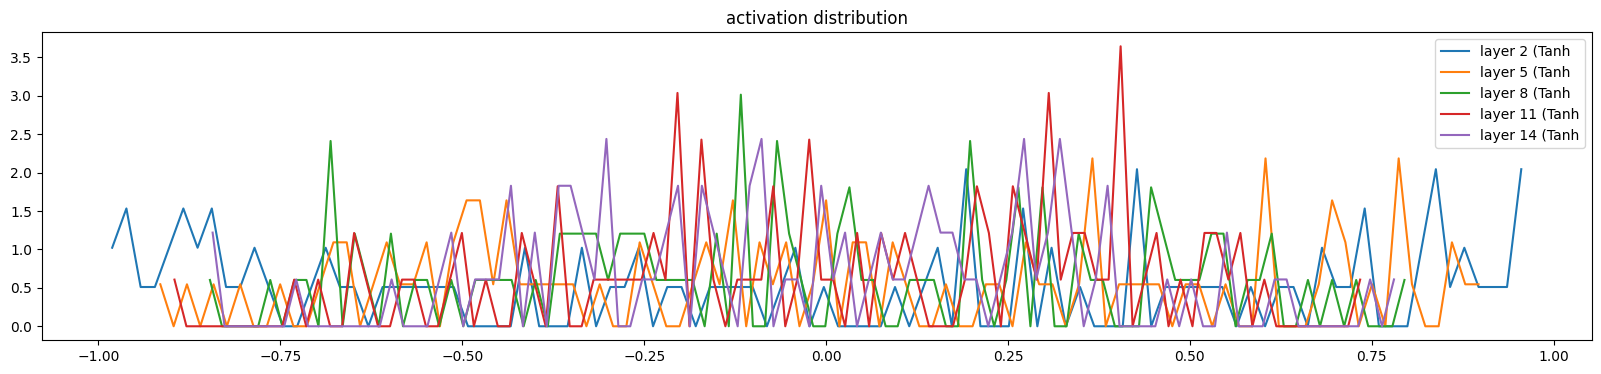

In [74]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

AttributeError: 'Tanh' object has no attribute 'out'

<Figure size 2000x400 with 0 Axes>

In [68]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [69]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


NameError: name 'ud' is not defined

<Figure size 2000x400 with 0 Axes>

In [70]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.297882318496704
val 3.2977380752563477


In [71]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduxlhggphhbmgpoinfqdqjtzsrlivwa.
vvdbquwqjehogdjaryxixfkqeupiusdbwed.
ecxia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojqmwycjsfrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxph.
xqioloqbprbvbbdn.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrnzazqnljydpk.
kvweskatimzamdtevl.
ky.
qdyctoorowooktbymomokibfcw.
zoinhzcs.
nu.
eoaiunqqeroqci.
ipjzykbadyigluglc.
fwzyzdjokhnlhfzqsxmuadmtjhvtoyaplwuw.
xisxwrdfv.
zphtzbiuzzsrvgmknbfyntiysfgdglnmmj.
pqgcrvdhpvdafpsdvkhzkxkimtvoocjupgawjmjqjwgvhflwkewtxarclxdctpvhgqllyuil.


In [ ]:
# DONE; BONUS content below, not covered in video

In [29]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [28]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [27]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
